Architecture


i/p -> 8 3x3 filters (8 feat maps) (CNN1 + batch norm + relu) -> Maxpool (feat_map_size/2) -> 4 filters (32 feat maps) (CNN2 + batch norm + relu) -> Max pool (feat_map_size/2) -> FC1 -> FC2 (o/p classification layer)

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [2]:
# mean and std of MNIST data set. Precomputed and available online.
# We need these values to perform data normalization.

mean_gray = 0.1307
stddev_gray = 0.3081

# Transformations that we want to apply to the image
# Transform MNIST img to tensor and normalize
# 
# input[channel] = (input[channel] - mean[channel]) / std[channel]. In gray scale we only have 1 channel. In color img, we have 3 channels (RGB).

transforms = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize((mean_gray,), (stddev_gray))])

train_dataset = datasets.MNIST(root = './mnist_dataset', 
                               train = True, 
                               transform = transforms,
                               download = True)
test_dataset = datasets.MNIST(root = './mnist_dataset',
                              train = False,
                              transform = transforms)

print(len(train_dataset))
print(len(test_dataset))

60000
10000


4


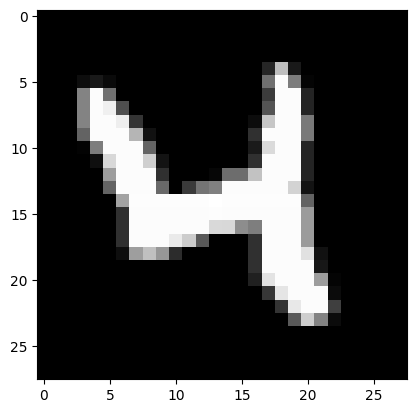

In [3]:
# train dataset - [[image, label]]
rand_img = train_dataset[20][0].numpy()

# We normalized the entire dataset with "transforms". So de-normalize before viewing.

rand_img = rand_img * stddev_gray + mean_gray
plt.imshow(rand_img.reshape(28, -1), cmap='gray')
print(train_dataset[20][1])

In [4]:
# data loader
batch_size = 100
train_load = torch.utils.data.DataLoader(dataset=train_dataset, 
                                         batch_size=batch_size,
                                         shuffle=True)

test_load = torch.utils.data.DataLoader(dataset=test_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False)

print(len(train_load)) # len(train_dataset)/batch_size
print(len(test_load))

600
100


In [5]:
# Building the CNN

# img -> 8 3x3 filters -> Max pool (feat_map_size/2) -> 32 filter ? -> Max pool -> FC1 -> FC2 (classification output layer)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        """
        CNN 1
        """
        # gray scale image. So 1 in channel. 8 filters so 8 out channels.  
        # for same padding (in img size = out feat map) padding = (filter_size - 1)/2
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        # output feat map size each = [(in_size - filter_size + 2*padding)/stride + 1] = 28
        # Batch normalization. Specify the number of feat maps. Apply batch norm to each feat map.
        self.batchnorm1 = nn.BatchNorm2d(8)
        self. relu = nn.ReLU()

        """
        Max Pool - same kernel size for both
        """
        # kernel size 2 => 4 elements replaced by 1.
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        # output size = in_size / 2 = 14

        """
        CNN 2
        """
        # Same padding. Use formula from CNN1 to calculate padding. 
        self.cnn2 = nn.Conv2d(in_channels = 8, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
        # output size = [(in_size - filter_size + 2*padding)/stride + 1] = 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        # Flatten 7*7*32 (after another max pool) = 1568
        self.fc1 = nn.Linear(1568,600) 
        # It is good practice to apply drop out b/w fully connected layers
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(600,10)
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
       
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        #Flatten before passing to linear layer
        out = out.view(-1, 1568)  # batch_size X Flatten img size.

        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out



In [6]:
model = CNN()


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [7]:
# Check tensor shapes

iter = 0
correct = 0

for i,(inputs,labels) in enumerate(train_load):

    # if GPU move inputs and labels to cuda as well.

    print("For one iteration: ")
    print(f"{inputs.shape = }")
    print(f"{labels.shape = }")
    output = model(inputs)
    print(f"{output.shape = }")
    _, predicted = torch.max(output, 1)
    print(f"{predicted = }")
    correct += (predicted==labels).sum()
    break


For one iteration: 
inputs.shape = torch.Size([100, 1, 28, 28])
labels.shape = torch.Size([100])


output.shape = torch.Size([100, 10])
predicted = tensor([2, 6, 2, 2, 9, 2, 2, 2, 2, 2, 8, 2, 2, 0, 8, 2, 2, 1, 2, 2, 2, 2, 9, 0,
        1, 2, 2, 2, 2, 0, 8, 2, 2, 8, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 9, 2, 2, 0,
        2, 2, 9, 4, 0, 4, 2, 8, 2, 6, 2, 2, 2, 9, 0, 3, 2, 9, 2, 2, 4, 9, 0, 3,
        2, 2, 8, 2, 0, 2, 0, 0, 2, 4, 3, 2, 2, 8, 2, 4, 2, 6, 2, 2, 4, 4, 0, 5,
        1, 2, 2, 2])


In [8]:
# Training the model

num_epochs = 10
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(num_epochs):
    correct = 0
    iter = 0
    iter_loss = 0.0

    # As we've used dropout and batch normalization, we need to set the model in train mode. These act differently in train and test mode. 
    model.train()

    for i, (inputs, labels) in enumerate(train_load):

        output = model(inputs) 
        loss = loss_fn(output, labels)

        iter_loss += loss.item() # Extracts the value out from a tensor

        # Now we need to back prop
        optimizer.zero_grad() # w <-- w - lr*gradient. We are clearing the gradient every iter.
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output , 1) # index corresponds to the correct label\
        correct += (predicted == labels).sum().item()

        iter += 1
    
    train_loss.append(iter_loss/iter) # avg. loss per iter
    train_acc.append(100*correct/len(train_dataset)) 

    # Testing phase
    iter_loss = 0.0
    correct = 0
    iter = 0

    model.eval()

    for i, (inputs, labels) in enumerate(test_load):

        test_output = model(inputs)

        loss = loss_fn(test_output, labels)
        iter_loss += loss.item()

        _, predicted = torch.max(test_output, 1)
        correct += (predicted == labels).sum().item()
        iter += 1
    
    test_loss.append(iter_loss/iter)
    test_acc.append(100*correct/len(test_dataset))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss[-1]:.3f}, Training Accuracy: {train_acc[-1]:.3f}, Testing loss: {test_loss[-1]:.3f}, Testing accuracy: {test_acc[-1]:.3f}")


Epoch 1/10, Training Loss: 0.651, Training Accuracy: 81.748, Testing loss: 0.064, Testing accuracy: 98.040
Epoch 2/10, Training Loss: 0.177, Training Accuracy: 94.627, Testing loss: 0.042, Testing accuracy: 98.670
Epoch 3/10, Training Loss: 0.104, Training Accuracy: 97.048, Testing loss: 0.045, Testing accuracy: 98.630
Epoch 4/10, Training Loss: 0.084, Training Accuracy: 97.712, Testing loss: 0.048, Testing accuracy: 98.760
Epoch 5/10, Training Loss: 0.070, Training Accuracy: 98.022, Testing loss: 0.036, Testing accuracy: 98.990
Epoch 6/10, Training Loss: 0.063, Training Accuracy: 98.158, Testing loss: 0.041, Testing accuracy: 98.760
Epoch 7/10, Training Loss: 0.058, Training Accuracy: 98.373, Testing loss: 0.050, Testing accuracy: 98.500
Epoch 8/10, Training Loss: 0.062, Training Accuracy: 98.212, Testing loss: 0.038, Testing accuracy: 99.010
Epoch 9/10, Training Loss: 0.055, Training Accuracy: 98.447, Testing loss: 0.030, Testing accuracy: 99.190
Epoch 10/10, Training Loss: 0.051, Tr

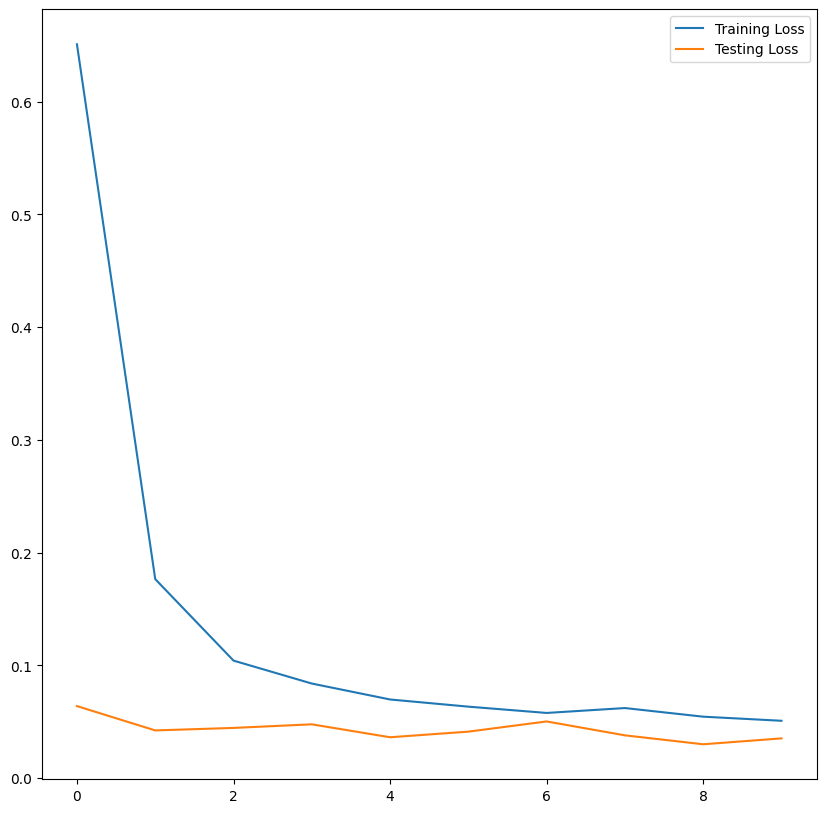

In [9]:
# Plotting the loss

f = plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

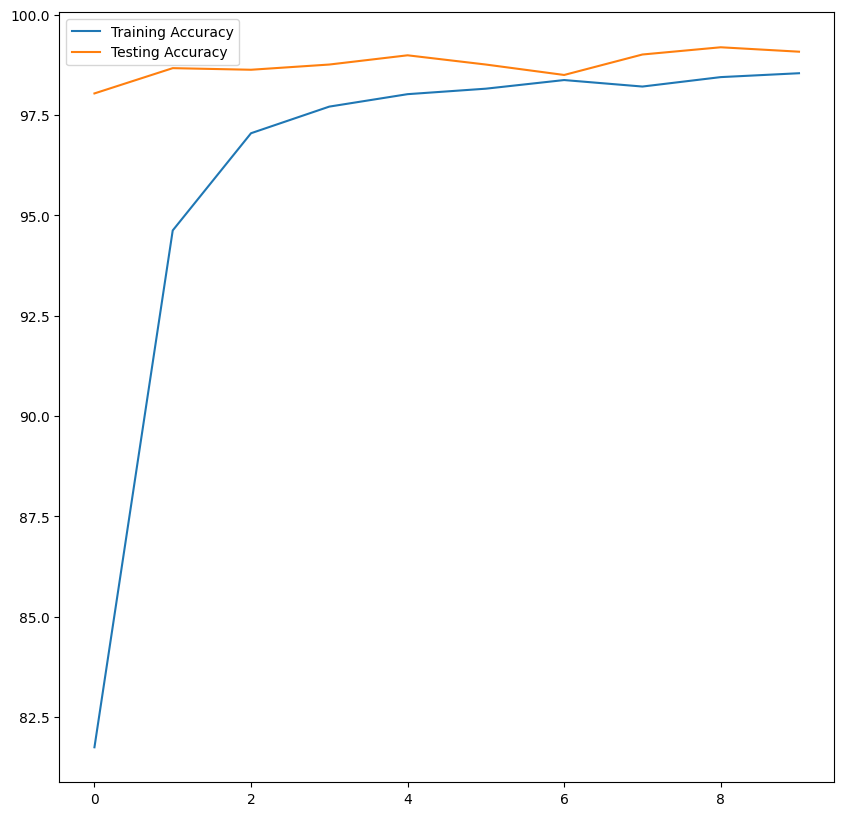

In [10]:
# Plotting the accuracy

f = plt.figure(figsize=(10,10))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.legend()
plt.show()

In [11]:
# Predict using the trained model

img = test_dataset[40][0].resize_((1,1,28,28))
label = test_dataset[40][1]

model.eval()

output = model(img)
_, pred = torch.max(output, 1)

print(f"{pred.item() = }")
print(f"{label = }")

pred.item() = 1
label = 1
